In [3]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# Paso 2: Cargar y explorar los datos
df = pd.read_csv('Housing_price_prediction.csv')
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
# Información general del dataset
print("Información del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None

Estadísticas descriptivas:
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    

In [6]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [7]:
# Paso 3: Preprocesamiento de datos

# Codificar variables categóricas
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                      'airconditioning', 'prefarea', 'furnishingstatus']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separar características numéricas para el clustering
features_for_clustering = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 
                         'mainroad', 'guestroom', 'basement', 'hotwaterheating',
                         'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

X = df[features_for_clustering]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Datos escalados - forma:", X_scaled.shape)
print("Primeras 5 filas escaladas:")
print(X_scaled[:5])

Datos escalados - forma: (545, 13)
Primeras 5 filas escaladas:
[[ 4.56636513  1.04672629  1.40341936  1.42181174  1.37821692  0.40562287
  -0.46531479 -0.73453933 -0.2192645   1.4726183   1.51769249  1.80494113
  -1.40628573]
 [ 4.00448405  1.75700953  1.40341936  5.40580863  2.53202371  0.40562287
  -0.46531479 -0.73453933 -0.2192645   1.4726183   2.67940935 -0.55403469
  -1.40628573]
 [ 4.00448405  2.21823241  0.04727831  1.42181174  0.22441013  0.40562287
  -0.46531479  1.3613975  -0.2192645  -0.67906259  1.51769249  1.80494113
  -0.09166185]
 [ 3.98575468  1.08362412  1.40341936  1.42181174  0.22441013  0.40562287
  -0.46531479  1.3613975  -0.2192645   1.4726183   2.67940935  1.80494113
  -1.40628573]
 [ 3.55497918  1.04672629  1.40341936 -0.57018671  0.22441013  0.40562287
   2.14908276  1.3613975  -0.2192645   1.4726183   1.51769249 -0.55403469
  -1.40628573]]


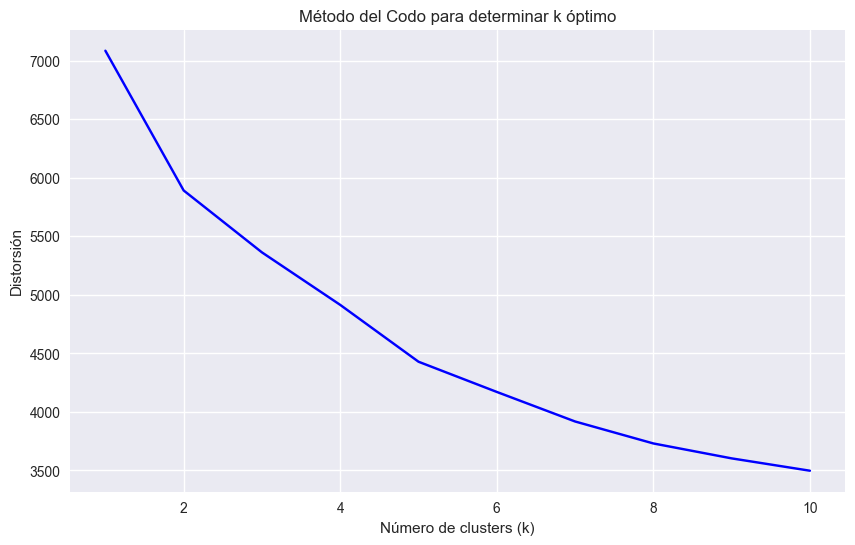

In [8]:
# Paso 4: Determinar el número óptimo de clusters

# Método del codo
def plot_elbow_method(X, max_k=10):
    distortions = []
    K = range(1, max_k+1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Distorsión')
    plt.title('Método del Codo para determinar k óptimo')
    plt.grid(True)
    plt.show()
    
    return distortions

distortions = plot_elbow_method(X_scaled)

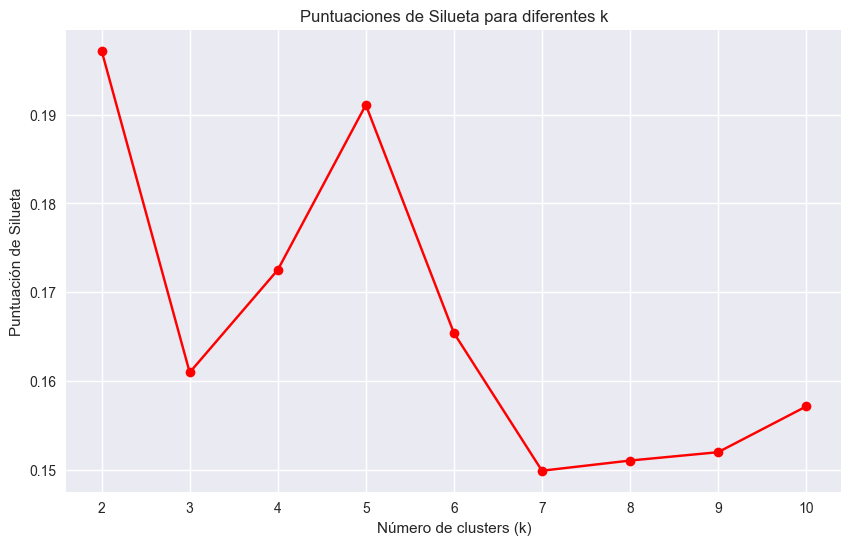

In [9]:
# Método de la silueta
def plot_silhouette_scores(X, max_k=10):
    silhouette_scores = []
    K = range(2, max_k+1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, silhouette_scores, 'ro-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Puntuación de Silueta')
    plt.title('Puntuaciones de Silueta para diferentes k')
    plt.grid(True)
    plt.show()
    
    return silhouette_scores

silhouette_scores = plot_silhouette_scores(X_scaled)

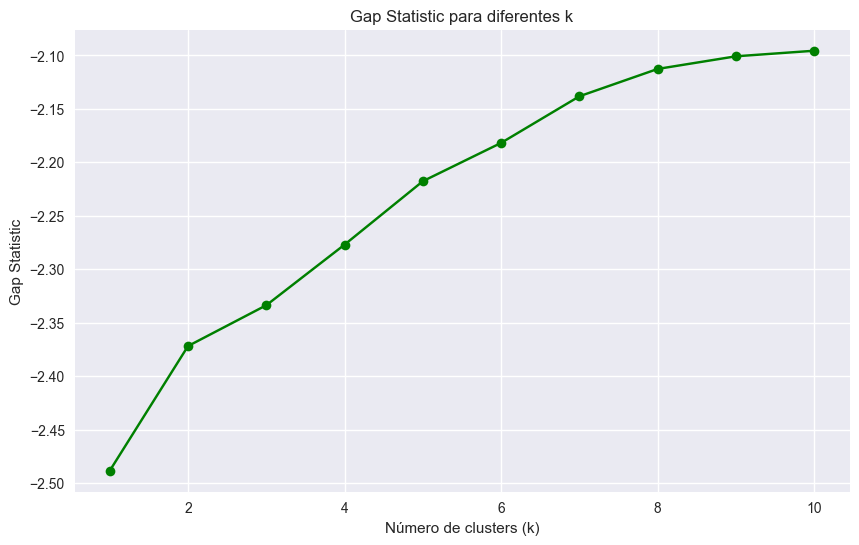

In [8]:
# Método Gap Statistic (simplificado)
def calculate_gap_statistic(X, max_k=10, n_refs=10):
    gaps = []
    K = range(1, max_k+1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        original_inertia = kmeans.inertia_
        
        # Generar datos de referencia
        reference_inertias = []
        for _ in range(n_refs):
            random_data = np.random.random_sample(size=X.shape)
            kmeans_random = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans_random.fit(random_data)
            reference_inertias.append(kmeans_random.inertia_)
        
        gap = np.log(np.mean(reference_inertias)) - np.log(original_inertia)
        gaps.append(gap)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, gaps, 'go-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic para diferentes k')
    plt.grid(True)
    plt.show()
    
    return gaps

gaps = calculate_gap_statistic(X_scaled)

In [9]:
# Análisis conjunto de los métodos
def analyze_optimal_k(elbow_scores, silhouette_scores, gap_scores):
    print("Análisis del número óptimo de clusters:")
    print(f"Elbow method sugiere: {np.argmax(np.diff(elbow_scores) < -np.std(np.diff(elbow_scores))) + 2}")
    print(f"Silhouette optimal: {np.argmax(silhouette_scores) + 2}")
    print(f"Gap statistic optimal: {np.argmax(gap_scores) + 1}")
    
    # Recomendación basada en silhouette (más confiable)
    optimal_k = np.argmax(silhouette_scores) + 2
    print(f"\nRecomendación: {optimal_k} clusters")
    return optimal_k

optimal_k = analyze_optimal_k(distortions, silhouette_scores, gaps)

Análisis del número óptimo de clusters:
Elbow method sugiere: 2
Silhouette optimal: 2
Gap statistic optimal: 10

Recomendación: 2 clusters


In [10]:
# Paso 5: Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Añadir las etiquetas de cluster al DataFrame original
df['cluster'] = cluster_labels

print(f"K-Means aplicado con {optimal_k} clusters")
print("Distribución de clusters:")
print(df['cluster'].value_counts().sort_index())

K-Means aplicado con 2 clusters
Distribución de clusters:
cluster
0    347
1    198
Name: count, dtype: int64


ANÁLISIS VISUAL DE CLUSTERS


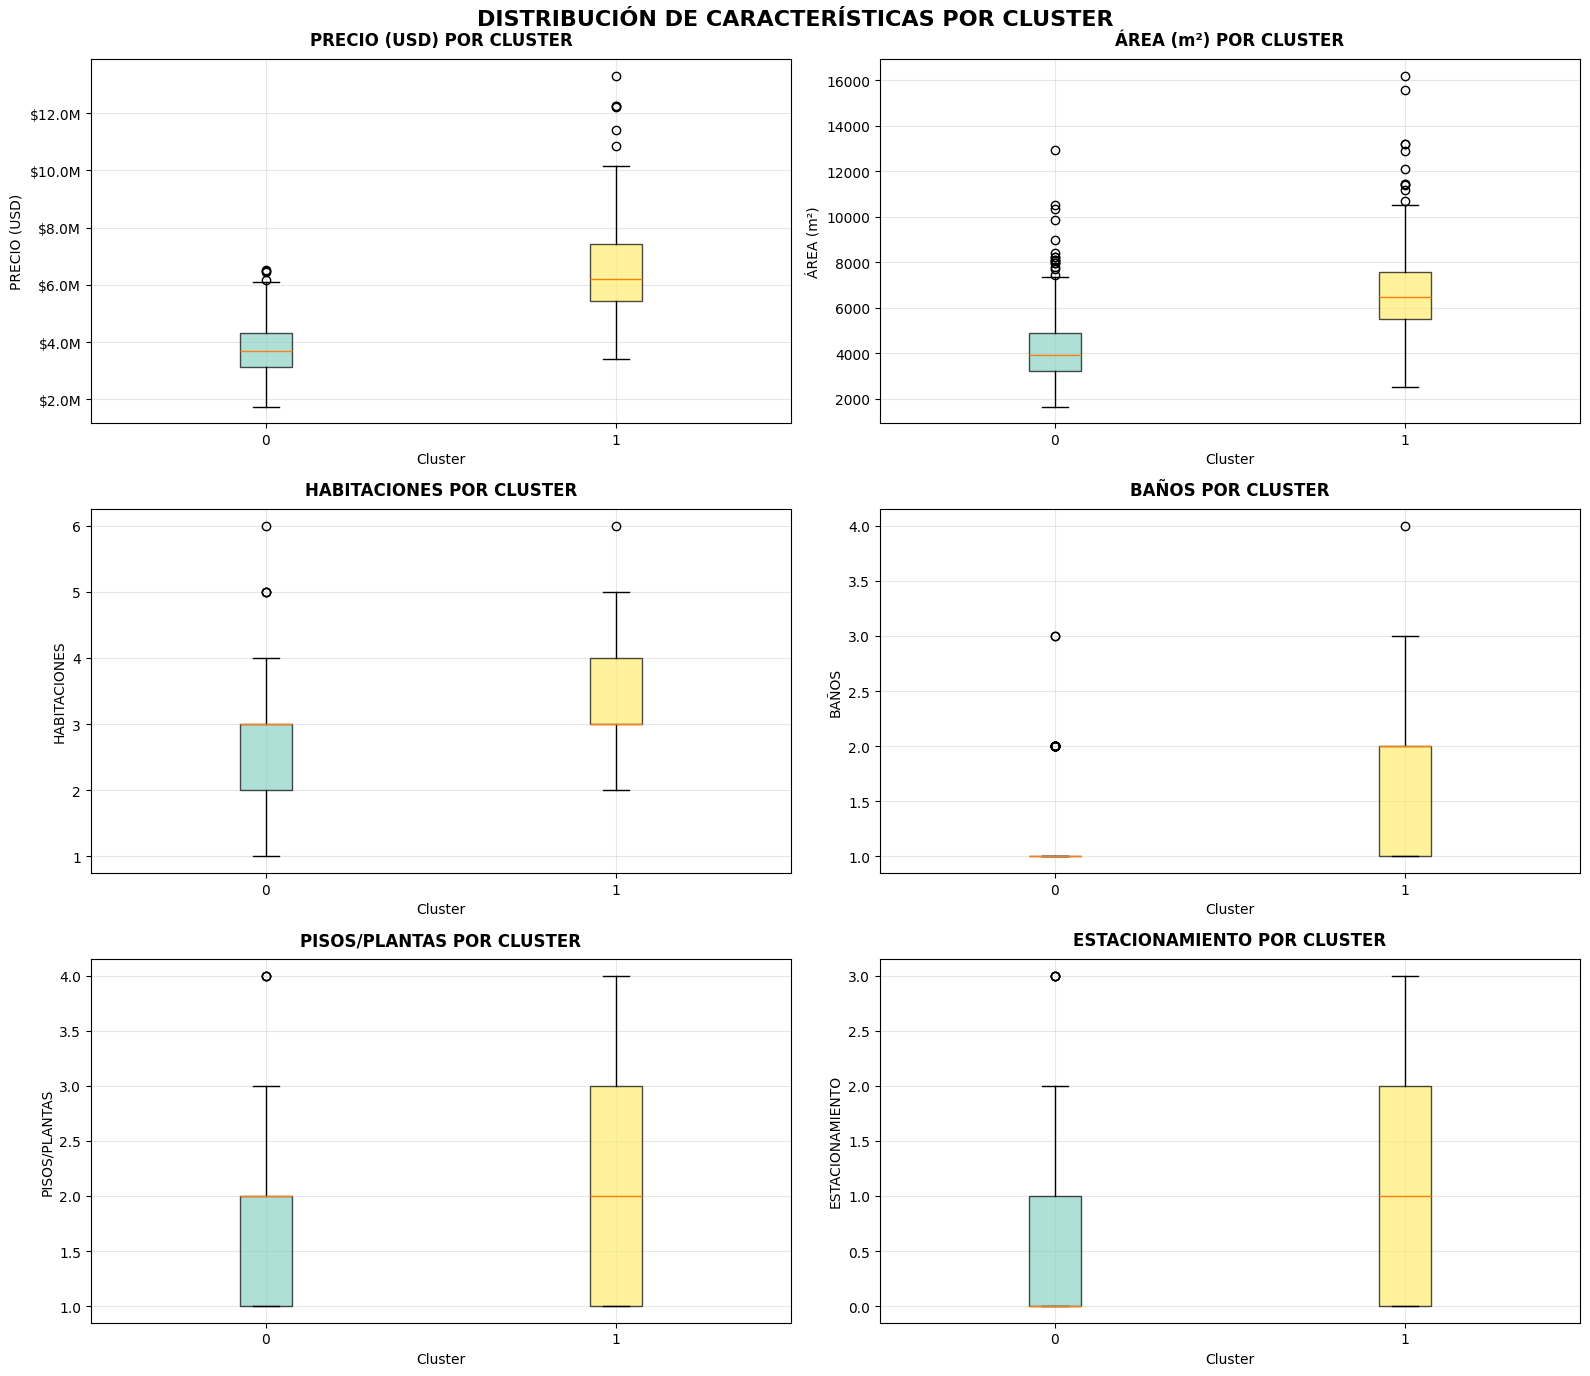

In [22]:

print("ANÁLISIS VISUAL DE CLUSTERS")

# 1. Boxplots individuales con control total
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Lista de variables y títulos claros
variables = [
    ('price', 'PRECIO (USD)', 'price'),
    ('area', 'ÁREA (m²)', 'area'), 
    ('bedrooms', 'HABITACIONES', 'bedrooms'),
    ('bathrooms', 'BAÑOS', 'bathrooms'),
    ('stories', 'PISOS/PLANTAS', 'stories'),
    ('parking', 'ESTACIONAMIENTO', 'parking')
]

for idx, (col, title, ax_type) in enumerate(variables):
    row, col_pos = idx // 2, idx % 2
    ax = axes[row, col_pos]
    
    # Crear boxplot
    box_data = [df[df['cluster'] == i][col] for i in sorted(df['cluster'].unique())]
    bp = ax.boxplot(box_data, patch_artist=True, labels=sorted(df['cluster'].unique()))
    
    # Colorear boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(box_data)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'{title} POR CLUSTER', fontweight='bold', pad=10)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
    
    # Formatear eje Y para precio
    if col == 'price':
        ax.ticklabel_format(style='plain', axis='y')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

plt.suptitle('DISTRIBUCIÓN DE CARACTERÍSTICAS POR CLUSTER', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

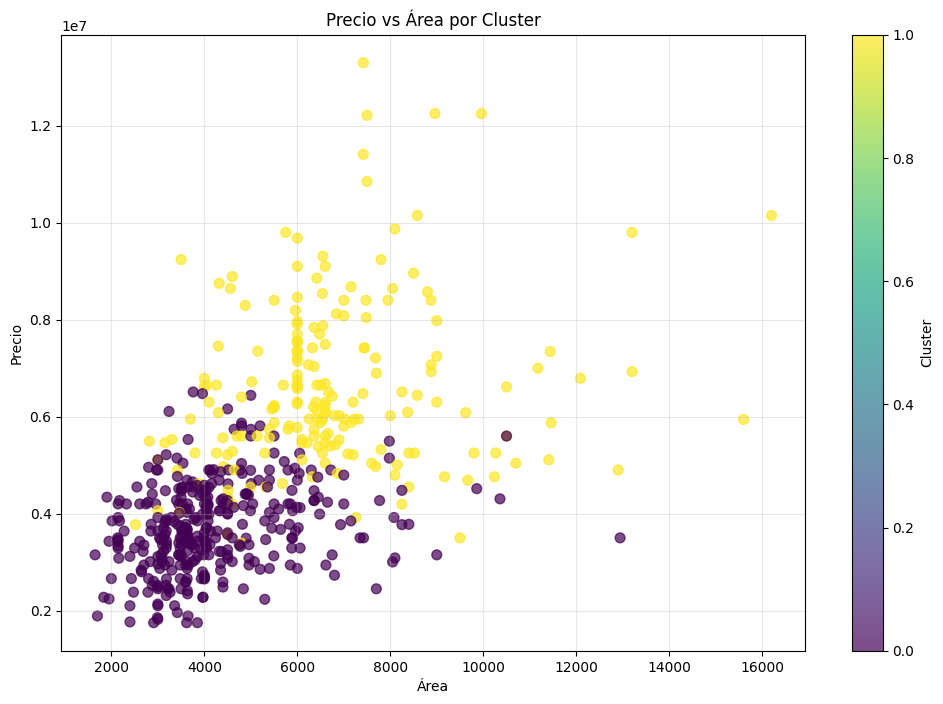

In [23]:
# Scatter plot de precio vs área coloreado por cluster
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['area'], df['price'], c=df['cluster'], 
                    cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Área')
plt.ylabel('Precio')
plt.title('Precio vs Área por Cluster')
plt.grid(True, alpha=0.3)
plt.show()

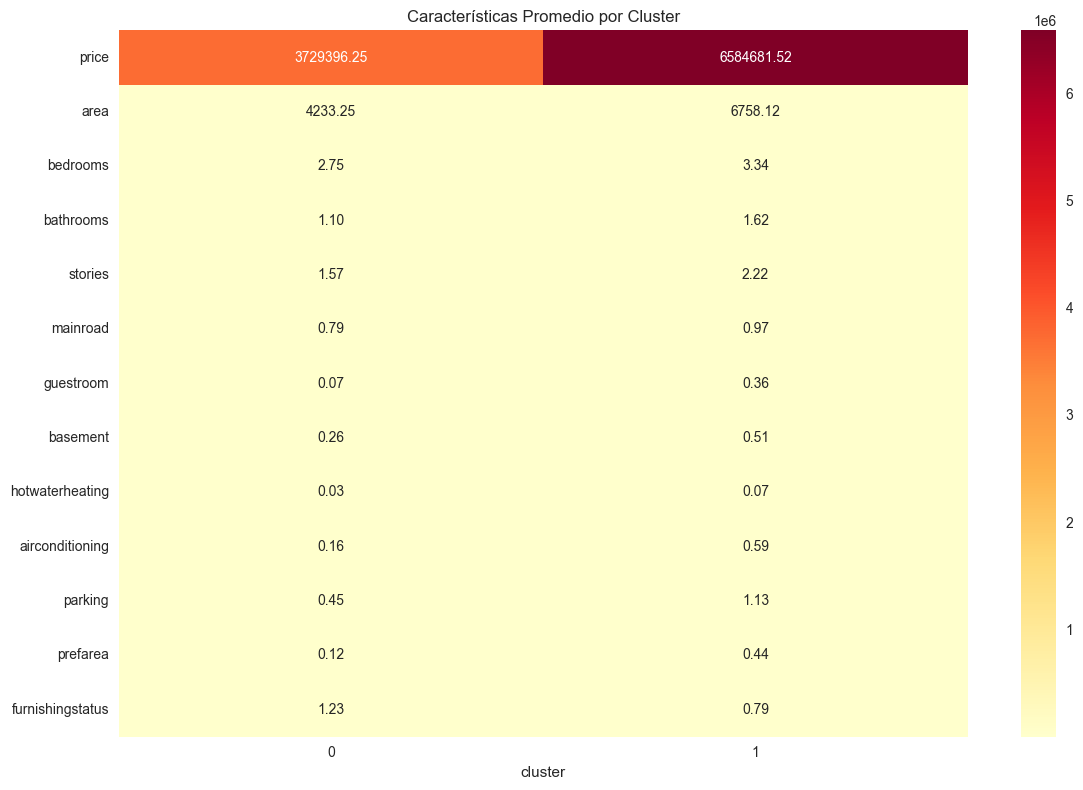

In [13]:
# Heatmap de características promedio por cluster
cluster_means = df.groupby('cluster')[features_for_clustering].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Características Promedio por Cluster')
plt.tight_layout()
plt.show()

In [14]:
# Análisis de los centroides
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)

centroids_df = pd.DataFrame(centroids_original, columns=features_for_clustering)
centroids_df['cluster'] = range(optimal_k)

print("Centroides de los clusters (valores originales):")
print(centroids_df.round(2))

Centroides de los clusters (valores originales):
        price     area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  3729396.25  4233.25      2.75       1.10     1.57      0.79       0.07   
1  6584681.52  6758.12      3.34       1.62     2.22      0.97       0.36   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0      0.26             0.03             0.16     0.45      0.12   
1      0.51             0.07             0.59     1.13      0.44   

   furnishingstatus  cluster  
0              1.23        0  
1              0.79        1  


In [15]:
# Perfiles de clusters
def describe_clusters(df, optimal_k):
    cluster_profiles = []
    
    for cluster in range(optimal_k):
        cluster_data = df[df['cluster'] == cluster]
        profile = {
            'cluster': cluster,
            'size': len(cluster_data),
            'avg_price': cluster_data['price'].mean(),
            'avg_area': cluster_data['area'].mean(),
            'avg_bedrooms': cluster_data['bedrooms'].mean(),
            'avg_bathrooms': cluster_data['bathrooms'].mean(),
            'price_range': f"{cluster_data['price'].min():.0f} - {cluster_data['price'].max():.0f}"
        }
        cluster_profiles.append(profile)
    
    return pd.DataFrame(cluster_profiles)

cluster_profiles = describe_clusters(df, optimal_k)
print("Perfiles de los clusters:")
print(cluster_profiles)

Perfiles de los clusters:
   cluster  size     avg_price     avg_area  avg_bedrooms  avg_bathrooms  \
0        0   347  3.729396e+06  4233.250720      2.752161       1.097983   
1        1   198  6.584682e+06  6758.116162      3.338384       1.616162   

          price_range  
0   1750000 - 6510000  
1  3395000 - 13300000  


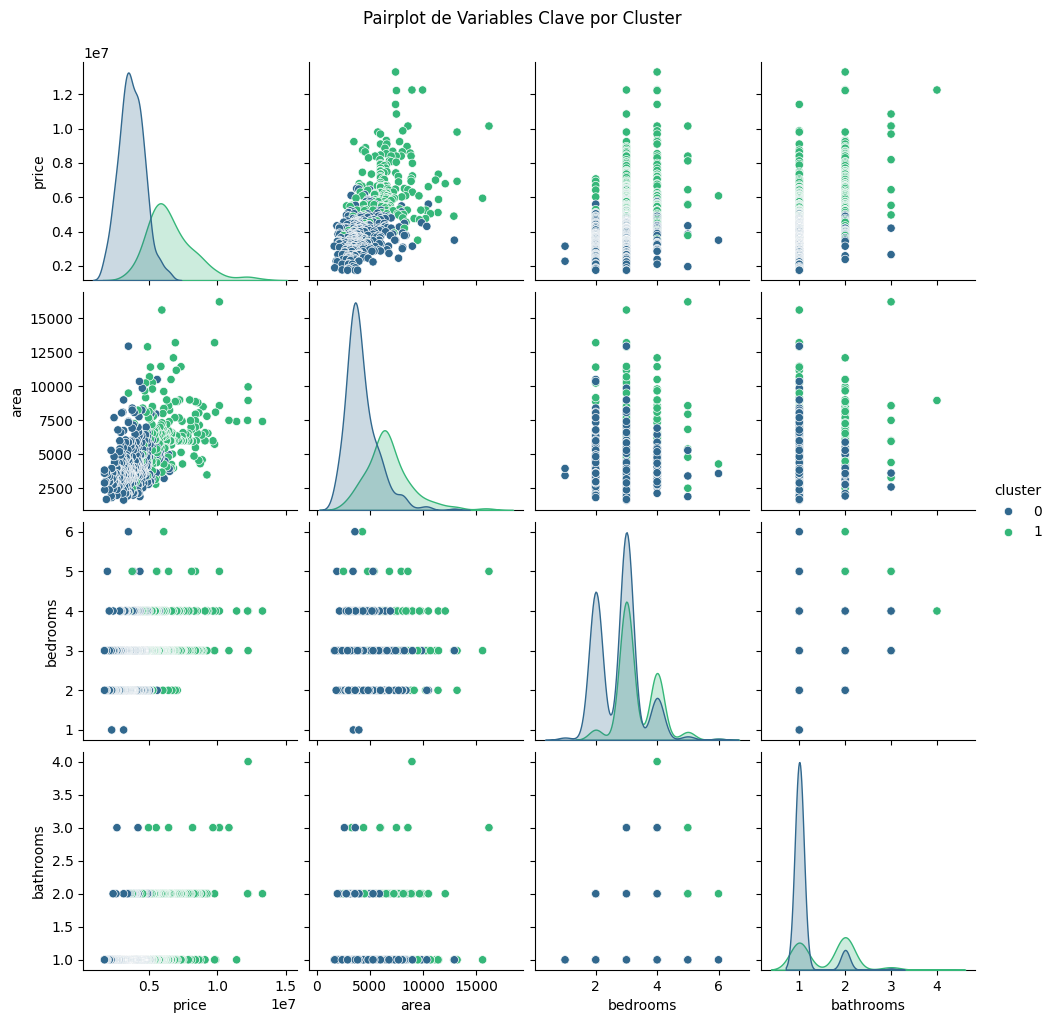

In [26]:
# Visualización adicional: Pairplot para algunas variables clave
key_vars = ['price', 'area', 'bedrooms', 'bathrooms', 'cluster']
sns.pairplot(df[key_vars], hue='cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot de Variables Clave por Cluster', y=1.02)
plt.show()

In [18]:
# Paso 7: Interpretación de resultados
print("="*50)
print("INTERPRETACIÓN DE RESULTADOS")
print("="*50)

for i in range(optimal_k):
    cluster_data = df[df['cluster'] == i]
    print(f"\n--- CLUSTER {i} ---")
    print(f"Tamaño: {len(cluster_data)} viviendas ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"Precio promedio: {cluster_data['price'].mean():,.0f}")
    print(f"Área promedio: {cluster_data['area'].mean():.0f} m²")
    print(f"Habitaciones promedio: {cluster_data['bedrooms'].mean():.1f}")
    print(f"Baños promedio: {cluster_data['bathrooms'].mean():.1f}")
    print(f"Parking promedio: {cluster_data['parking'].mean():.1f}")
    
    # Características destacadas
    if cluster_data['price'].mean() > df['price'].mean():
        price_level = "ALTO"
    else:
        price_level = "BAJO/MEDIO"
    
    print(f"Nivel de precio: {price_level}")

INTERPRETACIÓN DE RESULTADOS

--- CLUSTER 0 ---
Tamaño: 347 viviendas (63.7%)
Precio promedio: 3,729,396
Área promedio: 4233 m²
Habitaciones promedio: 2.8
Baños promedio: 1.1
Parking promedio: 0.4
Nivel de precio: BAJO/MEDIO

--- CLUSTER 1 ---
Tamaño: 198 viviendas (36.3%)
Precio promedio: 6,584,682
Área promedio: 6758 m²
Habitaciones promedio: 3.3
Baños promedio: 1.6
Parking promedio: 1.1
Nivel de precio: ALTO
